# **1. Recolección y procesamiento de datos**

**1.1 Carga de los Datos**


In [ ]:
# Carga de datos y Pytorch
#pytorch

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", DEVICE)

import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#Datos validación :
# Candidatos comunes en Colab (carpeta /content)

CANDIDATES_TRAIN = [
    "/content/adult.data"
]
CANDIDATES_TEST = [
    "/content/adult.test"
]

Usando dispositivo: cuda


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

COLS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

def read_adult(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, header=None, names=COLS, na_values=['?'], skipinitialspace=True)
    # Quitar puntos finales de la etiqueta (en test vienen así: '>50K.')
    df['income'] = df['income'].astype(str).str.replace(r'\\.$', '', regex=True).str.strip()
    return df

train_raw = read_adult(CANDIDATES_TRAIN[0])
test_raw  = read_adult(CANDIDATES_TEST[0])

print("Train shape:", train_raw.shape)
print("Test  shape:", test_raw.shape)

Train shape: (32561, 15)
Test  shape: (16282, 15)


In [ ]:
import pandas as pd

COLS = [
    'age','workclass','fnlwgt','education','education-num','marital-status',
    'occupation','relationship','race','sex','capital-gain','capital-loss',
    'hours-per-week','native-country','income'
]

def read_adult(path: str, is_test: bool=False):
    df = pd.read_csv(
        path,
        header=None,
        names=COLS,
        na_values=['?',' ?','? '],
        skipinitialspace=True,
        skiprows=1 if is_test else 0   # <- Omitir 1ª fila solo en adult.test
    )
    # Limpiar etiquetas (">50K." → ">50K")
    df['income'] = (
        df['income'].astype(str)
        .str.replace(r'\.$','', regex=True)
        .str.strip()
    )
    return df

# Vuelve a cargar desde cero
train_raw = read_adult("/content/adult.data", is_test=False)
test_raw  = read_adult("/content/adult.test", is_test=True)

print(train_raw.shape)
print(test_raw.shape)
print(train_raw.head())
print(test_raw.head())

(32561, 15)
(16281, 15)
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0   

**1.2 Split para obtener datos validación**

In [ ]:
#Datos validación

# Partición datos prueba
from sklearn.model_selection import train_test_split

test_split, valid_split = train_test_split(
    test_raw,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print("Tamaño datos de prueba (nuevo test):", test_split.shape)
print("Tamaño datos de validación:", valid_split.shape)

# Nuevas variables
nuevo_test = test_split.reset_index(drop=True)
validacion = valid_split.reset_index(drop=True)

Tamaño datos de prueba (nuevo test): (8140, 15)
Tamaño datos de validación: (8141, 15)


In [ ]:
from sklearn.model_selection import train_test_split

# Definir la variable objetivo
target = "income"

# Variables predictoras (X) y target (y) en entrenamiento
X_train = train_raw.drop(columns=[target])
y_train = train_raw[[target]]

# Para test_raw (antes de hacer split 50/50 a valid/test)
X_test_full = test_raw.drop(columns=[target])
y_test_full = test_raw[[target]]

# Ahora split 50/50 del test en validación y test final
X_test, X_val, y_test, y_val = train_test_split(
    X_test_full, y_test_full,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val:",   X_val.shape,   "| y_val:",   y_val.shape)
print("X_test:",  X_test.shape,  "| y_test:",  y_test.shape)

X_train: (32561, 14) | y_train: (32561, 1)
X_val: (8141, 14) | y_val: (8141, 1)
X_test: (8140, 14) | y_test: (8140, 1)


**1.3 Exploratory Data Analysis (EDA).**

Dimensiones del dataset: (32561, 15)

Primeras filas:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



Info de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Valores faltantes por columna:
age                  0
workclass     

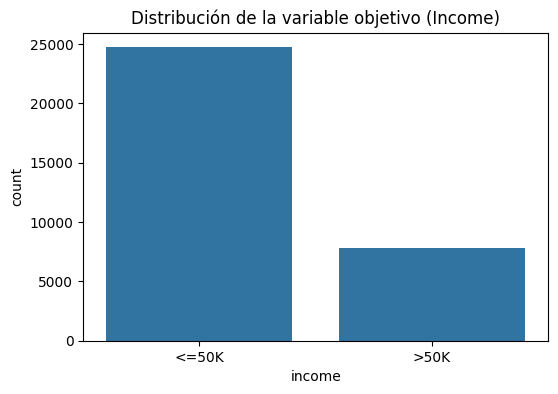


Estadísticas descriptivas (numéricas):


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000



Estadísticas descriptivas (categóricas):


,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


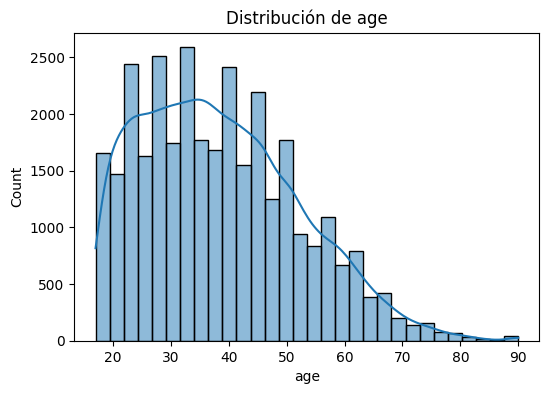

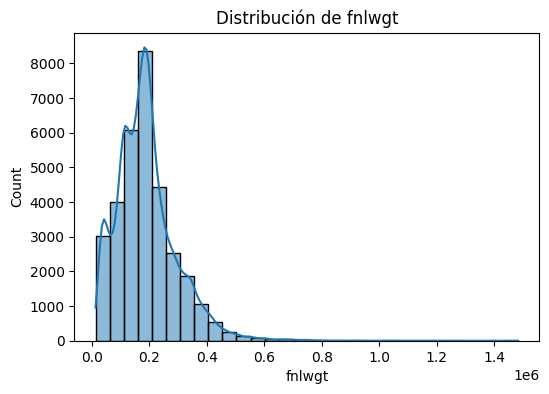

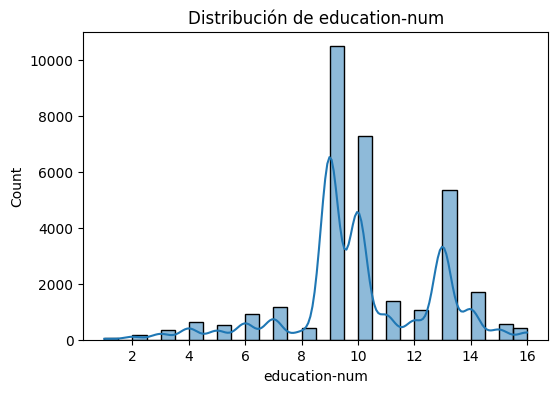

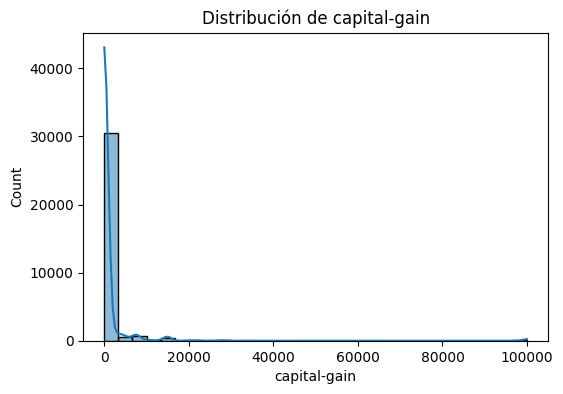

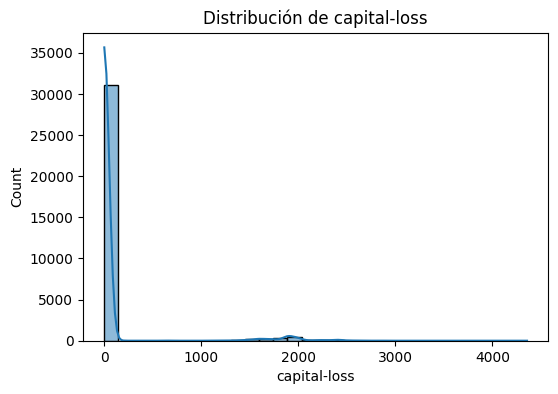

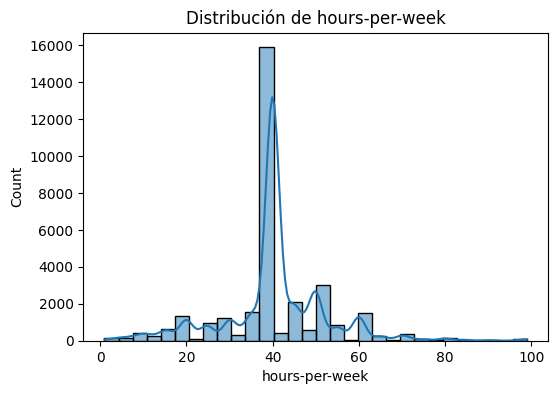

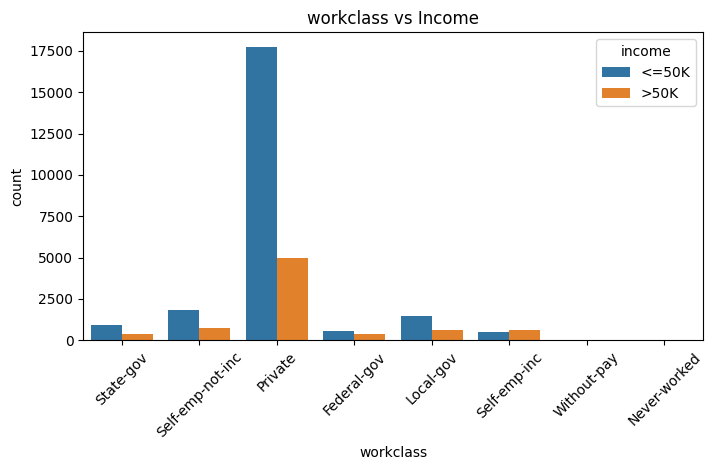

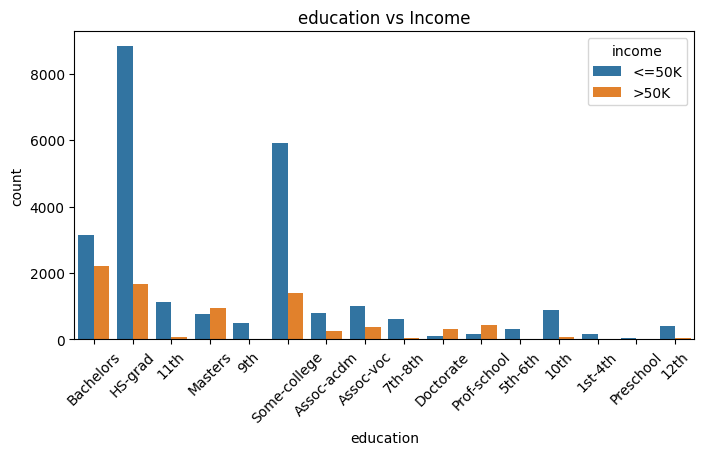

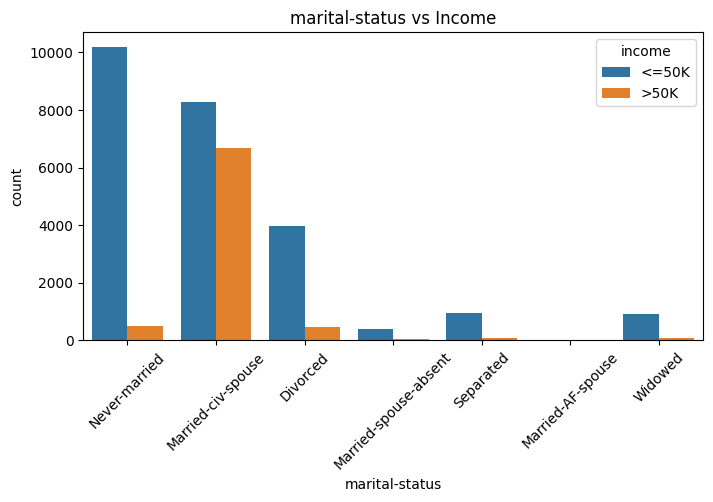

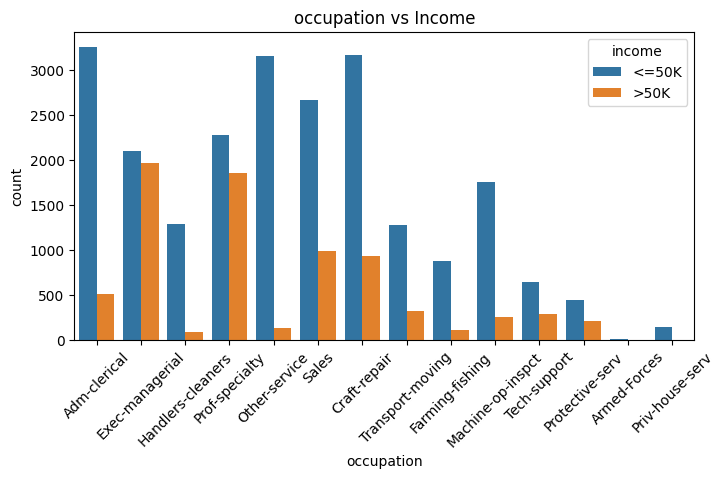

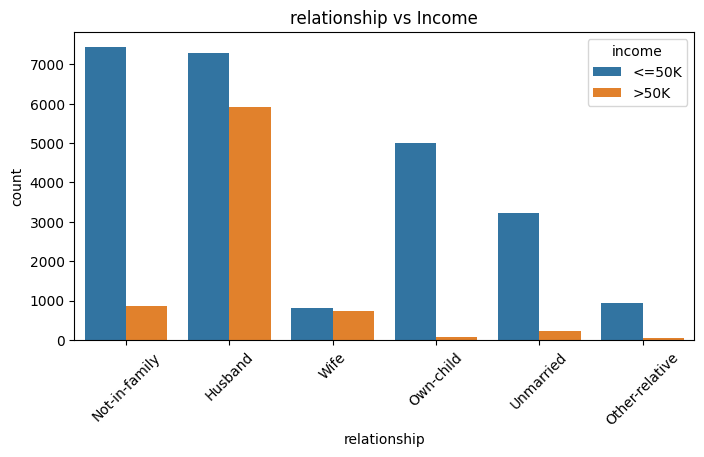

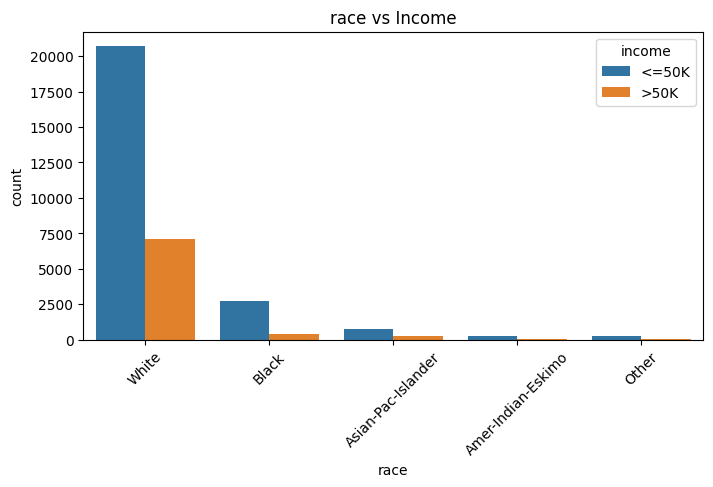

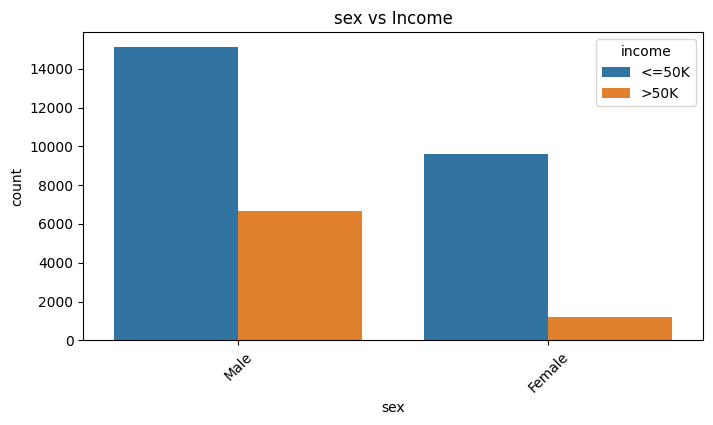

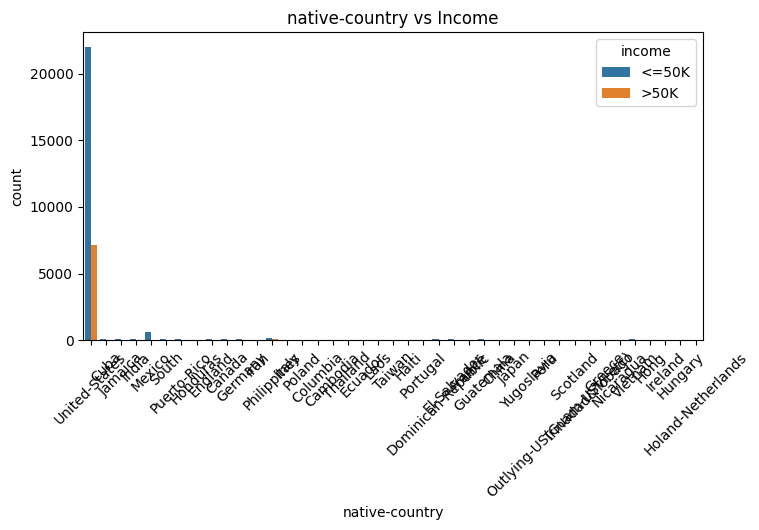

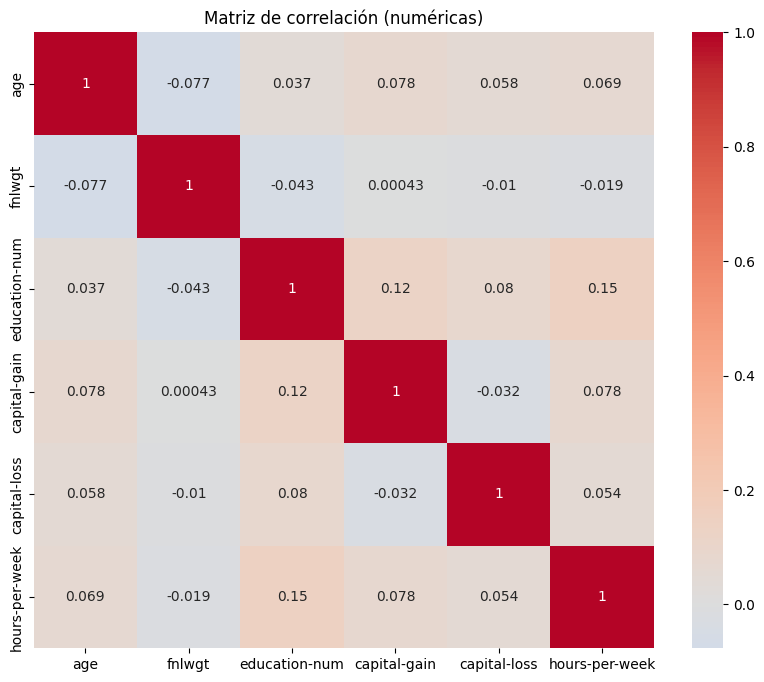

In [ ]:
# Exploratory Data Analysis (EDA) sobre adult.data

import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 1. Información general
# ==========================
print("Dimensiones del dataset:", train_raw.shape)
print("\nPrimeras filas:")
display(train_raw.head())

print("\nInfo de columnas:")
print(train_raw.info())

print("\nValores faltantes por columna:")
print(train_raw.isnull().sum())

# ==========================
# 2. Distribución de la variable objetivo (income)
# ==========================
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=train_raw)
plt.title("Distribución de la variable objetivo (Income)")
plt.show()

# ==========================
# 3. Estadísticas descriptivas
# ==========================
print("\nEstadísticas descriptivas (numéricas):")
display(train_raw.describe())

print("\nEstadísticas descriptivas (categóricas):")
display(train_raw.describe(include=['O']))

# ==========================
# 4. Distribuciones de variables numéricas
# ==========================
num_cols = train_raw.select_dtypes(include=np.number).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_raw[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.show()

# ==========================
# 5. Variables categóricas vs Income
# ==========================
cat_cols = train_raw.select_dtypes(include='object').columns.drop('income')

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='income', data=train_raw)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Income")
    plt.show()

# ==========================
# 6. Correlación entre variables numéricas
# ==========================
plt.figure(figsize=(10,8))
corr = train_raw[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (numéricas)")
plt.show()

**1.4 Procesamiento de datos**

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# === 1) Definir columnas ===
NUMERIC_FEATURES = ['age', 'fnlwgt', 'education-num',
                    'capital-gain', 'capital-loss', 'hours-per-week']

CATEGORICAL_FEATURES = [c for c in X_train.columns if c not in NUMERIC_FEATURES]

# === 2) ColumnTransformer ===
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), NUMERIC_FEATURES),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATEGORICAL_FEATURES),
])

# Ajustar SOLO con train (evita leakage)
preprocessor.fit(X_train)

# === 3) Transformar los conjuntos ===
X_train_transformed = preprocessor.transform(X_train).astype(np.float32)
X_val_transformed   = preprocessor.transform(X_val).astype(np.float32)
X_test_transformed  = preprocessor.transform(X_test).astype(np.float32)

print("Train shape:", X_train_transformed.shape)
print("Val shape:  ", X_val_transformed.shape)
print("Test shape: ", X_test_transformed.shape)


Train shape: (32561, 108)
Val shape:   (8141, 108)
Test shape:  (8140, 108)


# **2. Desarrollo de algoritmos**

**2.1 Modelo baseline**

In [ ]:
# Asegura que el target sea binario 0/1 y 1D
y_train = (train_raw['income'].astype(str).str.strip() == '>50K').astype(int).to_numpy().ravel()
y_val   = (valid_split['income'].astype(str).str.strip() == '>50K').astype(int).to_numpy().ravel()
y_test  = (test_split['income'].astype(str).str.strip() == '>50K').astype(int).to_numpy().ravel()

In [ ]:
#2.1.1 Realice un modelo de regresión logística y entrénelo
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#2.1.2 Obtenga las métricas (entrenamiento / validación / prueba)
set_seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

logreg = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
logreg.fit(X_train_transformed, y_train)

proba_tr = logreg.predict_proba(X_train_transformed)[:,1]
proba_va = logreg.predict_proba(X_val_transformed)[:,1]
proba_te = logreg.predict_proba(X_test_transformed)[:,1]

def metrics_block(y_true, y_prob, thr=0.5):
    y_hat = (y_prob >= thr).astype(int)
    return {
        "accuracy":  accuracy_score(y_true, y_hat),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall":    recall_score(y_true, y_hat, zero_division=0),
        "f1":        f1_score(y_true, y_hat, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, y_prob),
    }

print("Baseline – Train:", metrics_block(y_train, proba_tr))
print("Baseline – Valid:", metrics_block(y_val,   proba_va))
print("Baseline – Test :", metrics_block(y_test,  proba_te))

Baseline – Train: {'accuracy': 0.8529836307238721, 'precision': 0.7378504672897196, 'recall': 0.6041321260043362, 'f1': 0.664329289671131, 'roc_auc': np.float64(0.9086598393268477)}
Baseline – Valid: {'accuracy': 0.8470703844736519, 'precision': 0.7108433734939759, 'recall': 0.5869109947643979, 'f1': 0.6429595640952108, 'roc_auc': np.float64(0.9015643787480433)}
Baseline – Test : {'accuracy': 0.8592137592137592, 'precision': 0.7509529860228716, 'recall': 0.6105371900826446, 'f1': 0.6735042735042736, 'roc_auc': np.float64(0.9093639933713786)}


**2.2 Modelo de Redes Neuronales**

In [ ]:
# 2.2.1 – Arquitectura base (MLP) en PyTorch
import torch
import torch.nn as nn

class MLP(nn.Module):
    """
    MLP para clasificación binaria (Adult Income).
    - in_dim:  dimensión de entrada (número de features después del preprocesamiento)
    - hidden:  lista con el número de neuronas por capa oculta
    - dropout: probabilidad de dropout (regularización)
    """
    def __init__(self, in_dim: int, hidden=[256, 128], dropout: float = 0.2):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout)]
            d = h
        # Capa de salida: 1 logit para clasificación binaria
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        # Inicialización He (buena para ReLU)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

In [ ]:
# 2.2.2 – Definir función de pérdida y optimizador
import torch
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_dim = X_train_transformed.shape[1]
model = MLP(in_dim=in_dim, hidden=[512, 256, 128], dropout=0.2).to(DEVICE)

N_pos = int(y_train.sum())
N_neg = int(len(y_train) - N_pos)
pos_weight = torch.tensor([(N_neg / max(1, N_pos))], dtype=torch.float32, device=DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# 2.2.3 – Loop de entrenamiento que incluye validación
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

# === Datasets y DataLoaders (usar las matrices transformadas) ===
BATCH_SIZE = 1024
EPOCHS = 60

Xtr_t = torch.from_numpy(X_train_transformed).to(torch.float32)
ytr_t = torch.from_numpy(y_train.astype(np.float32)).view(-1, 1)

Xva_t = torch.from_numpy(X_val_transformed).to(torch.float32)
yva_t = torch.from_numpy(y_val.astype(np.float32)).view(-1, 1)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=BATCH_SIZE, shuffle=False)

# Historial para 2.2.4
history = {"train_loss": [], "val_loss": [], "val_auc": []}

for epoch in range(1, EPOCHS + 1):
    # ----- Entrenamiento -----
    model.train()
    running_loss, n_samples = 0.0, 0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(xb)                    # (N,1) logits
        loss = criterion(logits, yb)          # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        n_samples += xb.size(0)

    train_loss = running_loss / max(1, n_samples)

    # ----- Validación -----
    model.eval()
    v_running_loss, v_n = 0.0, 0
    all_probs, all_true = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            logits = model(xb)
            v_loss = criterion(logits, yb)

            v_running_loss += v_loss.item() * xb.size(0)
            v_n += xb.size(0)

            probs = torch.sigmoid(logits)          # convertir logits -> probas
            all_probs.append(probs.detach().cpu().numpy())
            all_true.append(yb.detach().cpu().numpy())

    val_loss = v_running_loss / max(1, v_n)
    y_prob = np.vstack(all_probs).ravel()
    y_true = np.vstack(all_true).ravel().astype(int)
    val_auc = roc_auc_score(y_true, y_prob)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_auc"].append(val_auc)

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_auc={val_auc:.4f}")

Epoch 001 | train_loss=0.7162  val_loss=0.5888  val_auc=0.9033
Epoch 005 | train_loss=0.5547  val_loss=0.5641  val_auc=0.9098
Epoch 010 | train_loss=0.5341  val_loss=0.5665  val_auc=0.9099
Epoch 015 | train_loss=0.5156  val_loss=0.5703  val_auc=0.9087
Epoch 020 | train_loss=0.4968  val_loss=0.5898  val_auc=0.9061
Epoch 025 | train_loss=0.4762  val_loss=0.5967  val_auc=0.9060
Epoch 030 | train_loss=0.4524  val_loss=0.6215  val_auc=0.9033
Epoch 035 | train_loss=0.4341  val_loss=0.6673  val_auc=0.9020
Epoch 040 | train_loss=0.4167  val_loss=0.6885  val_auc=0.8995
Epoch 045 | train_loss=0.4001  val_loss=0.7310  val_auc=0.8960
Epoch 050 | train_loss=0.3839  val_loss=0.7607  val_auc=0.8953
Epoch 055 | train_loss=0.3742  val_loss=0.8888  val_auc=0.8934
Epoch 060 | train_loss=0.3599  val_loss=0.9035  val_auc=0.8920


Usando: cuda

Entrenando: mlp_1x128
[mlp_1x128] Ep 001 | loss_tr=0.5553 loss_va=0.4372 auc_va=0.8778
[mlp_1x128] Ep 005 | loss_tr=0.3187 loss_va=0.3206 auc_va=0.9036
[mlp_1x128] Ep 010 | loss_tr=0.3079 loss_va=0.3150 auc_va=0.9060
[mlp_1x128] Ep 015 | loss_tr=0.3031 loss_va=0.3125 auc_va=0.9075
[mlp_1x128] Ep 020 | loss_tr=0.3002 loss_va=0.3115 auc_va=0.9082
[mlp_1x128] Ep 025 | loss_tr=0.2966 loss_va=0.3108 auc_va=0.9085
[mlp_1x128] Ep 030 | loss_tr=0.2941 loss_va=0.3113 auc_va=0.9085
[mlp_1x128] Ep 035 | loss_tr=0.2917 loss_va=0.3113 auc_va=0.9085
[mlp_1x128] Ep 040 | loss_tr=0.2895 loss_va=0.3117 auc_va=0.9084
[mlp_1x128] Ep 045 | loss_tr=0.2875 loss_va=0.3122 auc_va=0.9080
[mlp_1x128] Ep 050 | loss_tr=0.2854 loss_va=0.3120 auc_va=0.9082
[mlp_1x128] Ep 055 | loss_tr=0.2839 loss_va=0.3128 auc_va=0.9081
[mlp_1x128] Ep 060 | loss_tr=0.2820 loss_va=0.3131 auc_va=0.9078
[mlp_1x128] Ep 065 | loss_tr=0.2805 loss_va=0.3137 auc_va=0.9073
[mlp_1x128] Ep 070 | loss_tr=0.2792 loss_va=0.3171 auc

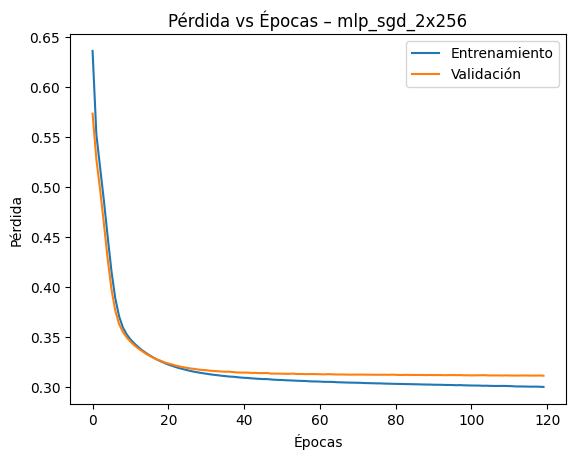

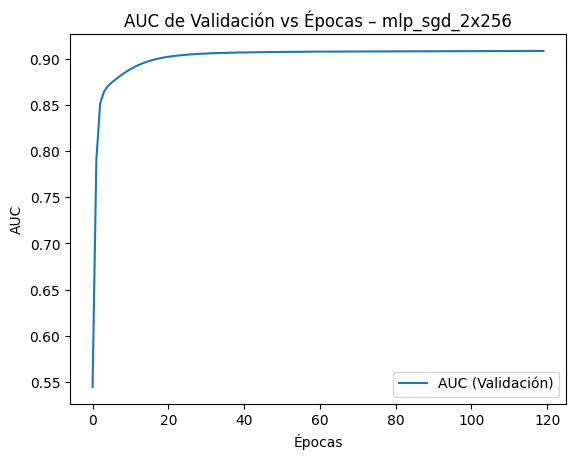

In [ ]:
# =============================================
# 2.2.4 – MLP sin regularización (criterio: AUC FINAL)
# =============================================

# Reproducibilidad mínima
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Dependencias
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", DEVICE)

# --------------------------
# DataLoaders (usa X_*_transformed, y_*)
# --------------------------
def make_loaders(batch=1024):
    ds_tr = TensorDataset(
        torch.from_numpy(X_train_transformed).float(),
        torch.from_numpy(y_train.astype(np.float32)).view(-1,1)
    )
    ds_va = TensorDataset(
        torch.from_numpy(X_val_transformed).float(),
        torch.from_numpy(y_val.astype(np.float32)).view(-1,1)
    )
    ds_te = TensorDataset(
        torch.from_numpy(X_test_transformed).float(),
        torch.from_numpy(y_test.astype(np.float32)).view(-1,1)
    )
    return (
        DataLoader(ds_tr, batch_size=batch, shuffle=True),
        DataLoader(ds_va, batch_size=batch, shuffle=False),
        DataLoader(ds_te, batch_size=batch, shuffle=False),
    )

# --------------------------
# MLP básico (sin Dropout)
# --------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden):
        super().__init__()
        layers, d = [], in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# --------------------------
# Entrenamiento de un experimento
# --------------------------
def run_experiment(name, hidden, lr=1e-3, opt="adam", epochs=120, batch=1024):
    # fijar semillas por experimento para que tú y tu compañera obtengan lo mismo
    set_seed(42)

    dl_tr, dl_va, dl_te = make_loaders(batch)
    model = MLP(X_train_transformed.shape[1], hidden).to(DEVICE)
    crit = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) if opt.lower()=="sgd" \
            else torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "val_loss": [], "val_auc": []}

    for ep in range(1, epochs+1):
        # ---- train
        model.train(); run=0; n=0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optim.zero_grad()
            lg = model(xb)
            loss = crit(lg, yb)
            loss.backward(); optim.step()
            run += loss.item()*xb.size(0); n += xb.size(0)
        tr_loss = run/max(1,n)

        # ---- valid
        model.eval(); vrun=0; vn=0; probs=[]; ys=[]
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                lg = model(xb)
                vloss = crit(lg, yb)
                vrun += vloss.item()*xb.size(0); vn += xb.size(0)
                probs.append(torch.sigmoid(lg).cpu().numpy()); ys.append(yb.cpu().numpy())
        va_loss = vrun/max(1,vn)
        y_prob = np.vstack(probs).ravel(); y_true = np.vstack(ys).ravel().astype(int)
        va_auc = roc_auc_score(y_true, y_prob)

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["val_auc"].append(va_auc)

        if ep == 1 or ep % 5 == 0:
            print(f"[{name}] Ep {ep:03d} | loss_tr={tr_loss:.4f} loss_va={va_loss:.4f} auc_va={va_auc:.4f}")

    # ---- métricas finales (último estado: criterio AUC FINAL)
    def eval_dl(dl, thr=0.5):
        model.eval(); probs=[]; ys=[]
        with torch.no_grad():
            for xb, yb in dl:
                lg = model(xb.to(DEVICE))
                probs.append(torch.sigmoid(lg).cpu().numpy()); ys.append(yb.cpu().numpy())
        y_prob = np.vstack(probs).ravel()
        y_true = np.vstack(ys).ravel().astype(int)
        y_hat = (y_prob >= thr).astype(int)
        return dict(
            accuracy=accuracy_score(y_true, y_hat),
            precision=precision_score(y_true, y_hat, zero_division=0),
            recall=recall_score(y_true, y_hat, zero_division=0),
            f1=f1_score(y_true, y_hat, zero_division=0),
            roc_auc=roc_auc_score(y_true, y_prob),
        )

    return {
        "name": name,
        "config": {"hidden": hidden, "lr": lr, "opt": opt, "epochs": epochs, "batch": batch},
        "history": hist,
        "metrics": {"train": eval_dl(dl_tr), "valid": eval_dl(dl_va), "test": eval_dl(dl_te)}
    }

# --------------------------
# Configuraciones a probar
# --------------------------
experiments = [
    {"name":"mlp_1x128",            "hidden":[128],           "lr":1e-3, "opt":"adam"},
    {"name":"mlp_2x256",            "hidden":[256,256],       "lr":1e-3, "opt":"adam"},
    {"name":"mlp_3x512",            "hidden":[512,512,512],   "lr":1e-3, "opt":"adam"},
    {"name":"mlp_3x512-256-128",    "hidden":[512,256,128],   "lr":1e-3, "opt":"adam"},
    {"name":"mlp_sgd_2x256",        "hidden":[256,256],       "lr":5e-3, "opt":"sgd"},
]

# --------------------------
# Correr y seleccionar por AUC FINAL
# --------------------------
results_224 = []
for cfg in experiments:
    print("\nEntrenando:", cfg["name"])
    results_224.append(run_experiment(**cfg))

rows = []
for r in results_224:
    rows.append({
        "name": r["name"],
        "hidden": r["config"]["hidden"],
        "opt": r["config"]["opt"],
        "lr": r["config"]["lr"],
        "final_val_auc": r["history"]["val_auc"][-1],
        "final_val_loss": r["history"]["val_loss"][-1],
    })
tabla_224 = pd.DataFrame(rows).sort_values("final_val_auc", ascending=False)
print("\nResumen 2.2.4 (ordenado por AUC FINAL):")
print(tabla_224)

mejor = results_224[tabla_224.index[0]]
print(f"\n>>> Mejor 2.2.4 (AUC final): {mejor['name']}")
print("Config:", mejor["config"])
print("Valid:", mejor["metrics"]["valid"])
print("Test :", mejor["metrics"]["test"])

# --------------------------
# Gráficas del mejor
# --------------------------
h = mejor["history"]

plt.figure()
plt.plot(h["train_loss"], label="Entrenamiento")
plt.plot(h["val_loss"], label="Validación")
plt.xlabel("Épocas"); plt.ylabel("Pérdida")
plt.title(f"Pérdida vs Épocas – {mejor['name']}")
plt.legend(); plt.show()

plt.figure()
plt.plot(h["val_auc"], label="AUC (Validación)")
plt.xlabel("Épocas"); plt.ylabel("AUC")
plt.title(f"AUC de Validación vs Épocas – {mejor['name']}")
plt.legend(); plt.show()

Usando: cuda
[mlp_reg_3x512-256-128_do0.2] Ep 001 | loss_tr=0.4399 loss_va=0.3309 auc_va=0.9009
[mlp_reg_3x512-256-128_do0.2] Ep 005 | loss_tr=0.3034 loss_va=0.3118 auc_va=0.9092
[mlp_reg_3x512-256-128_do0.2] Ep 010 | loss_tr=0.2917 loss_va=0.3108 auc_va=0.9091
[mlp_reg_3x512-256-128_do0.2] Ep 015 | loss_tr=0.2755 loss_va=0.3160 auc_va=0.9063
[mlp_reg_3x512-256-128_do0.2] EarlyStopping @ ep 18

=== 2.2.5 – Resultados finales ===
Best val AUC: 0.9091776802526802
Valid: {'accuracy': 0.8508782704827417, 'precision': 0.6907894736842105, 'recall': 0.6596858638743456, 'f1': 0.674879485806106, 'roc_auc': np.float64(0.9091776802526802)}
Test : {'accuracy': 0.8594594594594595, 'precision': 0.7185430463576159, 'recall': 0.6725206611570248, 'f1': 0.6947705442902882, 'roc_auc': np.float64(0.9140591697038966)}


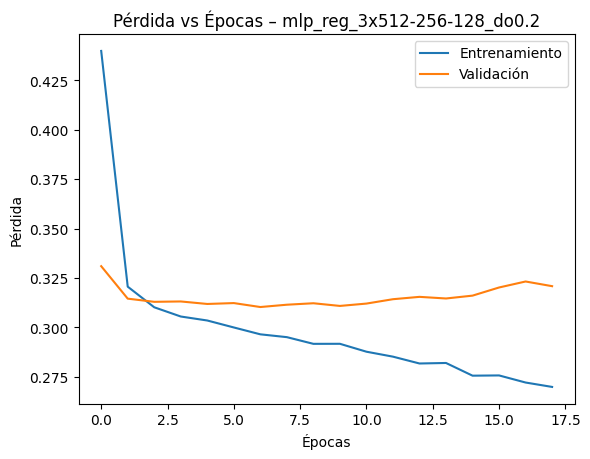

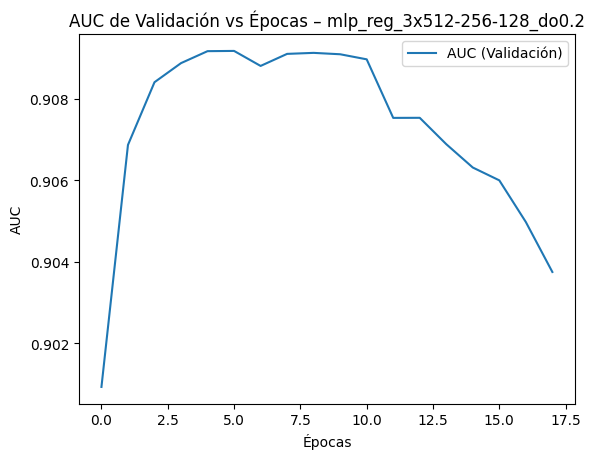

In [ ]:
# =============================================
# 2.2.5 – MLP con regularización (1 experimento)
# Dropout + EarlyStopping (+ opcional: weight decay)
# =============================================

# Reproducibilidad
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", DEVICE)

# ---------------------------------
# DataLoaders (usa X_*_transformed, y_*)
# ---------------------------------
def make_loaders(batch=1024):
    ds_tr = TensorDataset(
        torch.from_numpy(X_train_transformed).float(),
        torch.from_numpy(y_train.astype(np.float32)).view(-1,1)
    )
    ds_va = TensorDataset(
        torch.from_numpy(X_val_transformed).float(),
        torch.from_numpy(y_val.astype(np.float32)).view(-1,1)
    )
    ds_te = TensorDataset(
        torch.from_numpy(X_test_transformed).float(),
        torch.from_numpy(y_test.astype(np.float32)).view(-1,1)
    )
    return (
        DataLoader(ds_tr, batch_size=batch, shuffle=True),
        DataLoader(ds_va, batch_size=batch, shuffle=False),
        DataLoader(ds_te, batch_size=batch, shuffle=False),
    )

# ---------------------------------
# MLP con Dropout
# ---------------------------------
class MLPReg(nn.Module):
    def __init__(self, in_dim, hidden, dropout=0.2):
        super().__init__()
        layers, d = [], in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ---------------------------------
# EarlyStopping por AUC de validación
# ---------------------------------
class EarlyStopping:
    def __init__(self, patience=12, min_delta=0.0):
        self.patience=patience; self.min_delta=min_delta
        self.best=-np.inf; self.count=0; self.stop=False
    def step(self, val_auc):
        if val_auc > self.best + self.min_delta:
            self.best=val_auc; self.count=0
        else:
            self.count += 1
            if self.count >= self.patience: self.stop=True
        return self.stop

# ---------------------------------
# Entrenar un solo experimento regularizado
# ---------------------------------
def run_experiment_reg(
    name,
    hidden=[512,256,128],
    lr=1e-3,
    dropout=0.2,
    weight_decay=1e-5,
    epochs=150,
    patience=12,
    batch=1024,
    opt="adam"
):
    set_seed(42)  # misma inicialización cada vez
    dl_tr, dl_va, dl_te = make_loaders(batch)

    model = MLPReg(X_train_transformed.shape[1], hidden, dropout).to(DEVICE)
    crit = nn.BCEWithLogitsLoss()
    if opt.lower()=="sgd":
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    es = EarlyStopping(patience=patience)
    hist = {"train_loss":[], "val_loss":[], "val_auc":[]}
    best_auc, best_state = -np.inf, None

    for ep in range(1, epochs+1):
        # ---- train
        model.train(); run=0; n=0
        for xb,yb in dl_tr:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            optim.zero_grad()
            lg = model(xb)
            loss = crit(lg,yb)
            loss.backward(); optim.step()
            run += loss.item()*xb.size(0); n += xb.size(0)
        tr_loss = run/max(1,n)

        # ---- valid
        model.eval(); vrun=0; vn=0; probs=[]; ys=[]
        with torch.no_grad():
            for xb,yb in dl_va:
                xb,yb = xb.to(DEVICE), yb.to(DEVICE)
                lg = model(xb)
                vloss = crit(lg,yb)
                vrun += vloss.item()*xb.size(0); vn += xb.size(0)
                probs.append(torch.sigmoid(lg).cpu().numpy()); ys.append(yb.cpu().numpy())
        va_loss = vrun/max(1,vn)
        y_prob = np.vstack(probs).ravel(); y_true = np.vstack(ys).ravel().astype(int)
        va_auc = roc_auc_score(y_true, y_prob)

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["val_auc"].append(va_auc)

        if ep==1 or ep%5==0:
            print(f"[{name}] Ep {ep:03d} | loss_tr={tr_loss:.4f} loss_va={va_loss:.4f} auc_va={va_auc:.4f}")

        if va_auc > best_auc:
            best_auc = va_auc
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

        if es.step(va_auc):
            print(f"[{name}] EarlyStopping @ ep {ep}")
            break

    # restaurar mejores pesos
    if best_state is not None:
        model.load_state_dict(best_state)

    # ---- métricas finales
    def eval_dl(dl, thr=0.5):
        model.eval(); probs=[]; ys=[]
        with torch.no_grad():
            for xb,yb in dl:
                lg = model(xb.to(DEVICE))
                probs.append(torch.sigmoid(lg).cpu().numpy()); ys.append(yb.cpu().numpy())
        y_prob = np.vstack(probs).ravel()
        y_true = np.vstack(ys).ravel().astype(int)
        y_hat = (y_prob>=thr).astype(int)
        return dict(
            accuracy=accuracy_score(y_true,y_hat),
            precision=precision_score(y_true,y_hat,zero_division=0),
            recall=recall_score(y_true,y_hat,zero_division=0),
            f1=f1_score(y_true,y_hat,zero_division=0),
            roc_auc=roc_auc_score(y_true,y_prob),
        )

    m_tr = eval_dl(dl_tr); m_va = eval_dl(dl_va); m_te = eval_dl(dl_te)

    print("\n=== 2.2.5 – Resultados finales ===")
    print("Best val AUC:", float(best_auc))
    print("Valid:", m_va)
    print("Test :", m_te)

    # curvas
    plt.figure()
    plt.plot(hist["train_loss"], label="Entrenamiento")
    plt.plot(hist["val_loss"], label="Validación")
    plt.xlabel("Épocas"); plt.ylabel("Pérdida")
    plt.title(f"Pérdida vs Épocas – {name}")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(hist["val_auc"], label="AUC (Validación)")
    plt.xlabel("Épocas"); plt.ylabel("AUC")
    plt.title(f"AUC de Validación vs Épocas – {name}")
    plt.legend(); plt.show()

    return {
        "name": name,
        "config": {"hidden":hidden,"lr":lr,"dropout":dropout,"weight_decay":weight_decay,
                   "epochs":epochs,"patience":patience,"batch":batch,"opt":opt},
        "history": hist,
        "best_val_auc": float(best_auc),
        "metrics": {"train": m_tr, "valid": m_va, "test": m_te},
        "model": model
    }

# ---- Ejecutar UN experimento (ajusta si quieres otra config)
res_225 = run_experiment_reg(
    name="mlp_reg_3x512-256-128_do0.2",
    hidden=[512,256,128],
    lr=1e-3,
    dropout=0.2,
    weight_decay=1e-5,
    epochs=150,
    patience=12,
    batch=1024,
    opt="adam"
)

Usando: cuda

Entrenando: exp1_2x256
[exp1_2x256] Ep 001 | loss_tr=0.4546 loss_va=0.3423 auc_va=0.8911
[exp1_2x256] Ep 005 | loss_tr=0.3054 loss_va=0.3120 auc_va=0.9082
[exp1_2x256] Ep 010 | loss_tr=0.2977 loss_va=0.3107 auc_va=0.9089
[exp1_2x256] Ep 015 | loss_tr=0.2881 loss_va=0.3126 auc_va=0.9082
[exp1_2x256] Ep 020 | loss_tr=0.2814 loss_va=0.3154 auc_va=0.9070
[exp1_2x256] EarlyStopping @ ep 22

Entrenando: exp2_3x512-256-128
[exp2_3x512-256-128] Ep 001 | loss_tr=0.4399 loss_va=0.3309 auc_va=0.9009
[exp2_3x512-256-128] Ep 005 | loss_tr=0.3034 loss_va=0.3118 auc_va=0.9092
[exp2_3x512-256-128] Ep 010 | loss_tr=0.2917 loss_va=0.3108 auc_va=0.9091
[exp2_3x512-256-128] Ep 015 | loss_tr=0.2755 loss_va=0.3160 auc_va=0.9063
[exp2_3x512-256-128] EarlyStopping @ ep 18

Entrenando: exp3_3x512-256-128_do0.3
[exp3_3x512-256-128_do0.3] Ep 001 | loss_tr=0.4440 loss_va=0.3351 auc_va=0.8993
[exp3_3x512-256-128_do0.3] Ep 005 | loss_tr=0.3056 loss_va=0.3112 auc_va=0.9092
[exp3_3x512-256-128_do0.3] Ep

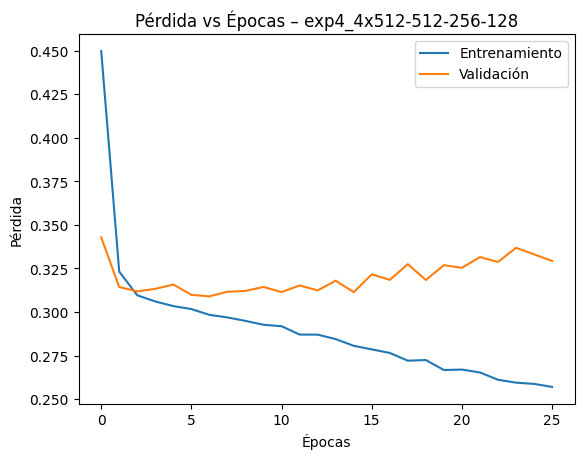

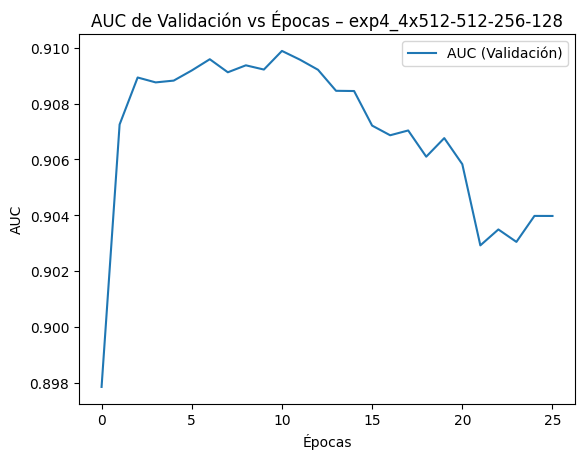

In [ ]:
# =============================================
# 2.2.6 – Barrido MLP con regularización (Dropout + EarlyStopping)
# =============================================

# Reproducibilidad
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Dependencias
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", DEVICE)

# ----------------------------
# DataLoaders (a partir de X*_transformed, y_*)
# ----------------------------
def make_loaders(batch=1024):
    ds_tr = TensorDataset(
        torch.from_numpy(X_train_transformed).float(),
        torch.from_numpy(y_train.astype(np.float32)).view(-1,1)
    )
    ds_va = TensorDataset(
        torch.from_numpy(X_val_transformed).float(),
        torch.from_numpy(y_val.astype(np.float32)).view(-1,1)
    )
    ds_te = TensorDataset(
        torch.from_numpy(X_test_transformed).float(),
        torch.from_numpy(y_test.astype(np.float32)).view(-1,1)
    )
    dl_tr = DataLoader(ds_tr, batch_size=batch, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=batch, shuffle=False)
    dl_te = DataLoader(ds_te, batch_size=batch, shuffle=False)
    return dl_tr, dl_va, dl_te

# ----------------------------
# Modelo con Dropout
# ----------------------------
class MLPReg(nn.Module):
    def __init__(self, in_dim, hidden, dropout=0.2):
        super().__init__()
        layers, d = [], in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ----------------------------
# EarlyStopping por AUC (valid)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=12, min_delta=0.0):
        self.patience = patience; self.min_delta = min_delta
        self.best = -np.inf; self.count = 0; self.stop = False
    def step(self, val_auc):
        if val_auc > self.best + self.min_delta:
            self.best = val_auc; self.count = 0
        else:
            self.count += 1
            if self.count >= self.patience: self.stop = True
        return self.stop

# ----------------------------
# Entrena un experimento regularizado
# ----------------------------
def run_experiment_reg(name, hidden, lr=1e-3, dropout=0.2, weight_decay=0.0,
                       epochs=150, patience=12, batch=1024, opt="adam"):
    set_seed(42)  # misma inicialización en cada corrida
    dl_tr, dl_va, dl_te = make_loaders(batch)

    model = MLPReg(X_train_transformed.shape[1], hidden, dropout).to(DEVICE)
    crit = nn.BCEWithLogitsLoss()
    if opt.lower() == "sgd":
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    es = EarlyStopping(patience=patience)
    history = {"train_loss": [], "val_loss": [], "val_auc": []}
    best_auc, best_state = -np.inf, None

    for ep in range(1, epochs+1):
        # train
        model.train(); run=0; n=0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optim.zero_grad()
            lg = model(xb)
            loss = crit(lg, yb)
            loss.backward(); optim.step()
            run += loss.item()*xb.size(0); n += xb.size(0)
        tr_loss = run/max(1, n)

        # valid
        model.eval(); vrun=0; vn=0; probs=[]; ys=[]
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                lg = model(xb)
                vloss = crit(lg, yb)
                vrun += vloss.item()*xb.size(0); vn += xb.size(0)
                probs.append(torch.sigmoid(lg).cpu().numpy()); ys.append(yb.cpu().numpy())
        va_loss = vrun/max(1, vn)
        y_prob = np.vstack(probs).ravel(); y_true = np.vstack(ys).ravel().astype(int)
        va_auc = roc_auc_score(y_true, y_prob)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["val_auc"].append(va_auc)

        if ep == 1 or ep % 5 == 0:
            print(f"[{name}] Ep {ep:03d} | loss_tr={tr_loss:.4f} loss_va={va_loss:.4f} auc_va={va_auc:.4f}")

        if va_auc > best_auc:
            best_auc = va_auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if es.step(va_auc):
            print(f"[{name}] EarlyStopping @ ep {ep}")
            break

    # conservar mejores pesos (mejor AUC de validación)
    if best_state is not None:
        model.load_state_dict(best_state)

    # métricas helper
    def eval_dl(dl, thr=0.5):
        model.eval(); probs=[]; ys=[]
        with torch.no_grad():
            for xb, yb in dl:
                lg = model(xb.to(DEVICE))
                probs.append(torch.sigmoid(lg).cpu().numpy()); ys.append(yb.cpu().numpy())
        y_prob = np.vstack(probs).ravel()
        y_true = np.vstack(ys).ravel().astype(int)
        y_hat = (y_prob >= thr).astype(int)
        return dict(
            accuracy=accuracy_score(y_true, y_hat),
            precision=precision_score(y_true, y_hat, zero_division=0),
            recall=recall_score(y_true, y_hat, zero_division=0),
            f1=f1_score(y_true, y_hat, zero_division=0),
            roc_auc=roc_auc_score(y_true, y_prob),
        )

    metrics = {
        "train": eval_dl(dl_tr),
        "valid": eval_dl(dl_va),
        "test":  eval_dl(dl_te),
    }

    return {
        "name": name,
        "config": {
            "hidden": hidden, "lr": lr, "dropout": dropout, "weight_decay": weight_decay,
            "epochs": epochs, "patience": patience, "batch": batch, "opt": opt
        },
        "history": history,
        "best_val_auc": float(best_auc),
        "metrics": metrics,
        "model": model
    }

# ----------------------------
# Configuraciones (≥ 5)
# ----------------------------
exp_reg = [
    {"name":"exp1_2x256",              "hidden":[256,256],         "lr":1e-3, "dropout":0.20, "weight_decay":0.0,  "epochs":150, "patience":12, "batch":1024, "opt":"adam"},
    {"name":"exp2_3x512-256-128",      "hidden":[512,256,128],     "lr":1e-3, "dropout":0.20, "weight_decay":1e-5, "epochs":150, "patience":12, "batch":1024, "opt":"adam"},
    {"name":"exp3_3x512-256-128_do0.3","hidden":[512,256,128],     "lr":1e-3, "dropout":0.30, "weight_decay":1e-5, "epochs":150, "patience":15, "batch":1024, "opt":"adam"},
    {"name":"exp4_4x512-512-256-128",  "hidden":[512,512,256,128], "lr":1e-3, "dropout":0.20, "weight_decay":1e-4, "epochs":180, "patience":15, "batch":1024, "opt":"adam"},
    {"name":"exp5_sgd_2x256",          "hidden":[256,256],         "lr":5e-3, "dropout":0.20, "weight_decay":0.0,  "epochs":200, "patience":20, "batch":1024, "opt":"sgd"},
]

# ----------------------------
# Correr y resumir
# ----------------------------
set_seed(42)
results_226 = []
for cfg in exp_reg:
    print("\nEntrenando:", cfg["name"])
    results_226.append(run_experiment_reg(**cfg))

rows = []
for r in results_226:
    rows.append({
        "name": r["name"],
        "hidden": r["config"]["hidden"],
        "dropout": r["config"]["dropout"],
        "lr": r["config"]["lr"],
        "wd": r["config"]["weight_decay"],
        "opt": r["config"]["opt"],
        "patience": r["config"]["patience"],
        "best_val_auc": r["best_val_auc"],
        "val_acc": r["metrics"]["valid"]["accuracy"],
        "val_f1": r["metrics"]["valid"]["f1"],
    })
tabla_226 = pd.DataFrame(rows).sort_values(by="best_val_auc", ascending=False)
print("\nResumen 2.2.6 (ordenado por best_val_auc):")
print(tabla_226)

best_226 = max(results_226, key=lambda r: r["best_val_auc"])
print("\n>>> Mejor 2.2.6:", best_226["name"])
print("Config:", best_226["config"])
print("Valid:", best_226["metrics"]["valid"])
print("Test :", best_226["metrics"]["test"])

# ----------------------------
# Gráficas del mejor
# ----------------------------
h = best_226["history"]

plt.figure()
plt.plot(h["train_loss"], label="Entrenamiento")
plt.plot(h["val_loss"], label="Validación")
plt.xlabel("Épocas"); plt.ylabel("Pérdida")
plt.title(f"Pérdida vs Épocas – {best_226['name']}")
plt.legend(); plt.show()

plt.figure()
plt.plot(h["val_auc"], label="AUC (Validación)")
plt.xlabel("Épocas"); plt.ylabel("AUC")
plt.title(f"AUC de Validación vs Épocas – {best_226['name']}")
plt.legend(); plt.show()

Evaluando modelo: exp4_4x512-512-256-128
Umbral elegido por F1 (validación): 0.350

=== 2.2.7 – Resultados finales (umbral validación por F1) ===
Train: {'accuracy': 0.8570682718589724, 'precision': 0.6682859858485585, 'recall': 0.8070399183777579, 'f1': 0.7311380704794916, 'roc_auc': np.float64(0.9291963499677448)}
Valid: {'accuracy': 0.8408057978135364, 'precision': 0.6315338474721508, 'recall': 0.7717277486910995, 'f1': 0.6946277097078228, 'roc_auc': np.float64(0.9098855074399999)}
Test : {'accuracy': 0.8423832923832923, 'precision': 0.6414032048505847, 'recall': 0.7649793388429752, 'f1': 0.6977620730270907, 'roc_auc': np.float64(0.9129726606001993)}

Classification report (VALID):
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      6231
           1       0.63      0.77      0.69      1910

    accuracy                           0.84      8141
   macro avg       0.78      0.82      0.79      8141
weighted avg       0.86      0.84

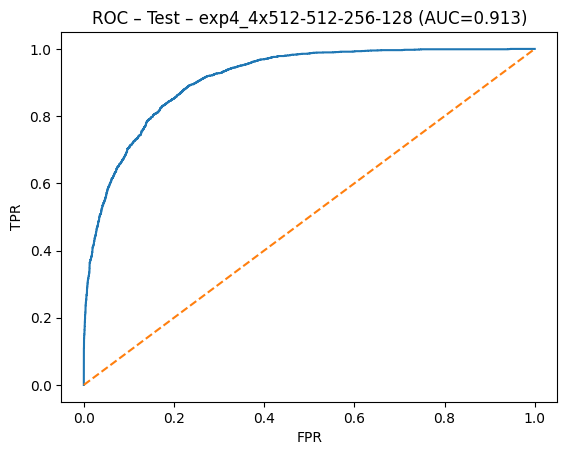

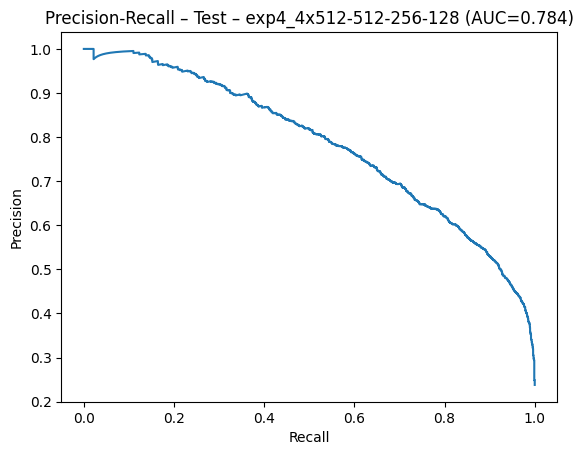

In [ ]:
# =============================================
# 2.2.7 – Evaluación final del MEJOR MLP (de 2.2.6)
# Métricas completas + matrices de confusión + reportes
# =============================================

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
)
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- tomar el mejor modelo obtenido en 2.2.6 ---
best_model = best_226["model"].to(DEVICE)
best_name  = best_226["name"]
print("Evaluando modelo:", best_name)

def eval_split(model, X, y, bs=1024, thr=0.5):
    dl = DataLoader(
        TensorDataset(torch.from_numpy(X).float(),
                      torch.from_numpy(y.astype(np.float32)).view(-1,1)),
        batch_size=bs, shuffle=False
    )
    model.eval(); probs=[]; ys=[]
    with torch.no_grad():
        for xb, yb in dl:
            lg = model(xb.to(DEVICE))
            probs.append(torch.sigmoid(lg).cpu().numpy())
            ys.append(yb.cpu().numpy())
    y_prob = np.vstack(probs).ravel()
    y_true = np.vstack(ys).ravel().astype(int)
    y_hat  = (y_prob >= thr).astype(int)
    metrics = dict(
        accuracy  = accuracy_score(y_true, y_hat),
        precision = precision_score(y_true, y_hat, zero_division=0),
        recall    = recall_score(y_true, y_hat, zero_division=0),
        f1        = f1_score(y_true, y_hat, zero_division=0),
        roc_auc   = roc_auc_score(y_true, y_prob),
    )
    return metrics, y_true, y_hat, y_prob

# --- umbral: opcional, ajustarlo en validación para mejor F1 ---
m_va_raw, y_va_raw, h_va_raw, p_va_raw = eval_split(best_model, X_val_transformed, y_val, thr=0.5)
fpr, tpr, thr_roc = roc_curve(y_va_raw, p_va_raw)
prec, rec, thr_pr = precision_recall_curve(y_va_raw, p_va_raw)

# seleccionar umbral que maximiza F1 en validación (opcional; si no lo quieres, deja thr=0.5)
f1s = []
for t in np.linspace(0.1, 0.9, 81):
    f1s.append(f1_score(y_va_raw, (p_va_raw>=t).astype(int), zero_division=0))
best_thr = float(np.linspace(0.1,0.9,81)[int(np.argmax(f1s))])
print(f"Umbral elegido por F1 (validación): {best_thr:.3f}")

# --- métricas finales con ese umbral ---
m_tr, y_tr, h_tr, p_tr = eval_split(best_model, X_train_transformed, y_train, thr=best_thr)
m_va, y_va, h_va, p_va = eval_split(best_model, X_val_transformed,   y_val,   thr=best_thr)
m_te, y_te, h_te, p_te = eval_split(best_model, X_test_transformed,  y_test,  thr=best_thr)

print("\n=== 2.2.7 – Resultados finales (umbral validación por F1) ===")
print("Train:", m_tr)
print("Valid:", m_va)
print("Test :", m_te)

# --- reportes y matrices de confusión ---
print("\nClassification report (VALID):\n", classification_report(y_va, h_va, zero_division=0))
print("Confusion matrix (VALID):\n", confusion_matrix(y_va, h_va))
print("\nClassification report (TEST):\n", classification_report(y_te, h_te, zero_division=0))
print("Confusion matrix (TEST):\n", confusion_matrix(y_te, h_te))

# --- curvas ROC y PR en TEST ---
fpr_te, tpr_te, _ = roc_curve(y_te, p_te)
prec_te, rec_te, _ = precision_recall_curve(y_te, p_te)

plt.figure()
plt.plot(fpr_te, tpr_te)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC – Test – {best_name} (AUC={roc_auc_score(y_te, p_te):.3f})")
plt.show()

plt.figure()
plt.plot(rec_te, prec_te)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision-Recall – Test – {best_name} (AUC={auc(rec_te, prec_te):.3f})")
plt.show()